Create database

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# import engarde.decorators as ed

import toolbox.toolbox as tb

pd.set_option('display.max_colwidth', None)




data = 'Schweizer-Nährwertdatenbank-V6.1.xlsx'
foods = tb.read(data)


my_foods = {
    'avocado, roh': 'avocado',
    'blattsalat (durchschnitt), roh': 'lettuce',
    'bier, lager': 'beer',
    'blumenkohl, gedämpft (ohne zugabe von salz)': 'cauliflower',
    'champignon, roh': 'mushrooms',    
    'feige, getrocknet': 'fig',
    'fleisch (durchschnitt exkl. innereien), roh': 'meat',
    'forelle, ganz, gekocht (ohne zusatz von fett und salz)': 'trout',
    'gemüse (durchschnitt), roh': 'vegetables',
    'hart- und halbhartkäse, vollfett (durchschnitt)': 'cheese',
    'haferflocken': 'oats',
    'halbentrahmte milch 1.5% fett, uht': 'milk',
    'hühnerei, ganz, festgekocht': 'eggs',
    'joghurt, mokka': 'mocca yoghurt',
    'joghurt, nature': 'nature yoghurt',
    'kakaopulver': 'cocoa powder', 
    'kartoffel, geschält, roh': 'potatoes',
    'kochbutter': 'butter',
    'kokosfett': 'coconut fat',
    'kokosnuss, getrocknet (kokosrapseln, kokosflocken)': 'coconut flakes',
    'mandel': 'almond',
    'olivenöl': 'olive oil',
    'peperoni, rot, roh': 'red pepper',
    'poulet, schenkel, mit haut, gebraten (ohne zusatz von fett und salz)': 'chicken leg',
    'poulet, brust, schnitzel oder geschnetzeltes, gebraten (ohne zusatz von fett und salz)': 'chicken breast',
    'reis poliert, gekocht in salzwasser (unjodiert)': 'rice',
    'samen, kerne, nüsse (durchschnitt), ungesalzen': 'nuts and seed mix',
    'schokolade, dunkel (bitter)': 'dark chocolate',
    'schwein, hals, steak, gebraten (ohne zusatz von fett und salz)': 'pork steak',
    'spinat, roh': 'spinach', 
    'tofu': 'tofu',
    'vollrahm, uht': 'cream'
}

myfoods = tb.make_myfoods(foods, my_foods).set_index('name')

Find items

In [2]:
tb.find_item(foods, 'bier')

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
57,"bier, alkoholfrei",alkoholhaltige getränke/bier,pro 100 ml,23,0.0,4.9,0.0,0.4,4.9
58,"bierhefe, getrocknet",speziallebensmittel/supplemente;verschiedenes/hefe,pro 100g essbarer Anteil,354,4.2,26.5,9.5,47.9,17.0
59,"bier, lager",alkoholhaltige getränke/bier,pro 100 ml,42,0.0,3.1,0.0,0.5,3.1
60,bier panache (durchschnitt),alkoholhaltige getränke/bier,pro 100 ml,39,0.0,7.4,0.0,0.2,7.4
61,bierwurst,fleisch- und wurstwaren/brühwurstware,pro 100g essbarer Anteil,350,31.3,0.0,0.0,16.8,0.0


In [7]:
meals = {
    
    'Breakfast': {
        'cauliflower': 1,
        'cheese': 1.5,
        'eggs': 2,
        'spinach': 0.5,
    },

    'Lunch': {
        'oats': 0.5,
        'milk': 1.5,        
        'yoghurt': 0.8,
        'lettuce': 1.5,
        'nuts and seed mix': .5,        
        'olive oil': .3,
        'tofu': 2,
    },

    'Supper': {
        'avocado': 2,
        'butter': 0,
        'trout': 2,
        'vegetables': 2,
    }
}

In [3]:
%run meals.ipynb

%store -r pa_meals
%store -r fa_meals

Stored 'pa_meals' (dict)


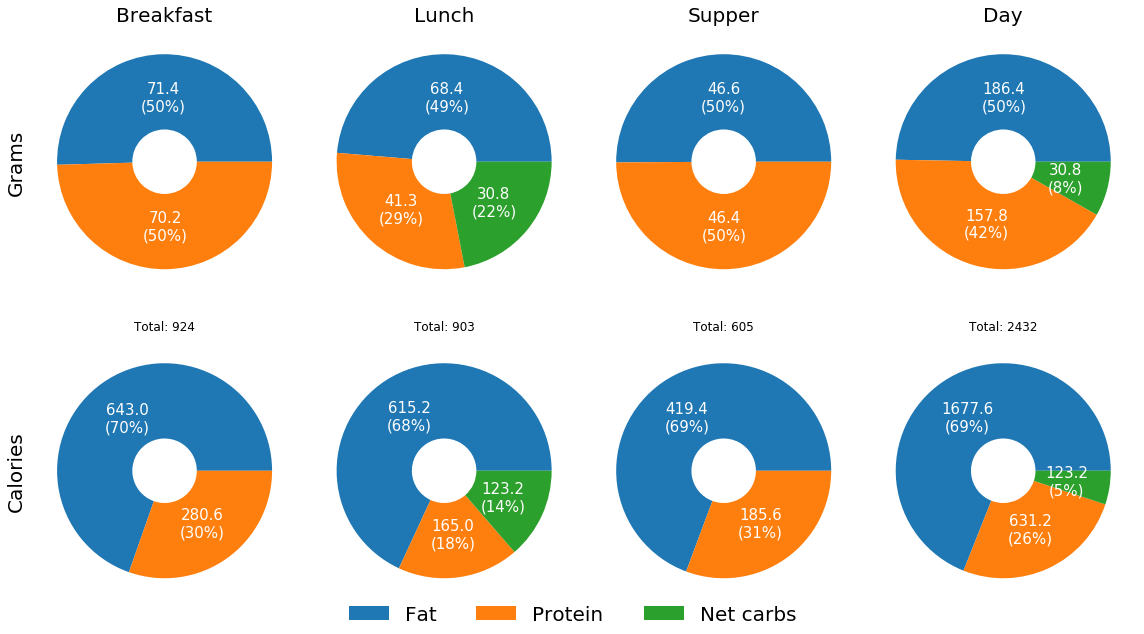

In [8]:
def calc_nutrients(data, meal):
    
    nutrients = ['calories', 'fat', 'protein', 'carbs', 'net_carbs']
    macros = ['fat', 'protein', 'carbs', 'net_carbs']
    portions = list(meal.values())
    
    data = (data.loc[data.index.isin(meal), nutrients]
            .reindex(meal)
            .multiply(portions, axis=0))
    
    grams = data[macros].copy().T.sum(1)
    grams[grams < 0] = 0
    
    cals = pd.Series(dtype='float')
    cals['fat'] = grams.fat * 9
    cals['protein'] = grams.protein * 4
    cals['carbs'] = grams.carbs * 4
    cals['net_carbs'] = grams.net_carbs * 4
    cals[cals < 0] = 0
    
    nuts = pd.concat([grams, cals], axis=1)
    nuts = nuts.reindex(['fat', 'protein', 'carbs', 'net_carbs'])
    nuts[nuts < 0] = 0
    nuts.columns = ['grams', 'cals']
    
    return nuts


def make_nuts_dict(meals):
    meal_nuts = {meal: calc_nutrients(myfoods, meals[meal]) for meal in meals}
    meal_nuts['Day'] = sum([meal_nuts[meal] for meal in meal_nuts])
    return meal_nuts


def make_dashboard(meals):
        
    rows = ['fat', 'protein', 'net_carbs']
    
    def make_doughnut(meal_data, column, axis, meal_num, meal_name):
        nuts = meal_data.loc[rows]
        
        def labs(pct, nuts):
            absolute = pct / 100 * nuts[column].sum()
            if absolute == 0:
                return f''
            else:
                return f'{absolute:.1f}\n({pct:.0f}%)'
        
        ax[axis, meal_num].pie(nuts[column],
                               autopct=lambda pct: labs(pct, nuts),
                               textprops=dict(color='white', size=15),
                               wedgeprops=dict(width=.7))
        
        ax[axis, meal_num].set_title(f'Total: {nuts[column].sum():.0f}')

    fig, ax = plt.subplots(2, len(meals), figsize=(16, 9))

    # Plot grams (top) and calories (bottom) for each meal
    for meal_num, meal_name in enumerate(meals):
        make_doughnut(meals[meal_name], 'grams', 0, meal_num, meal_name)
        make_doughnut(meals[meal_name], 'cals', 1, meal_num, meal_name)
        
    # Set column and row labels
    ax[0, 0].set_ylabel('Grams', fontsize=20)
    ax[1, 0].set_ylabel('Calories', fontsize=20)
    for col, name in enumerate(meals):
        ax[0, col].set_title(name, fontsize=20)
        
    legend_labs = [r.capitalize().replace('_', ' ') for r in rows]
    fig.legend(legend_labs, loc='lower center', ncol=3, fontsize=20, 
               framealpha=0, borderpad=0)
    fig.tight_layout()
        
    
meal_nuts = make_nuts_dict(meals)
make_dashboard(meal_nuts)